In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

df = pd.read_csv(r"C:\Users\johan\OneDrive - Universidad del Norte\Escritorio\MachineLearning\heart-disease-mlops\heart.csv")

df_encoded = pd.get_dummies(df, drop_first=True)

X = df_encoded.drop("HeartDisease", axis=1)
y = df_encoded["HeartDisease"]

import json

cols = X.columns.tolist()
with open(r"C:\Users\johan\OneDrive - Universidad del Norte\Escritorio\MachineLearning\heart-disease-mlops\training_columns.json", "w") as f:
    json.dump(cols, f)

print(f"✅ Guardadas {len(cols)} columnas en training_columns.json")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dimensiones de entrenamiento:", X_train.shape)
print("Dimensiones de prueba:", X_test.shape)



✅ Guardadas 15 columnas en training_columns.json
Dimensiones de entrenamiento: (734, 15)
Dimensiones de prueba: (184, 15)


In [ ]:
def train_pipeline(model, param_grid, X_train, y_train, X_test, y_test):
    pipe = Pipeline([
        ("scaler", MinMaxScaler()),
        ("clf", model)
    ])

    grid = GridSearchCV(
        pipe,
        param_grid=param_grid,
        cv=5,
        scoring="roc_auc",
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)
    y_prob = grid.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)

    return {
        "modelo": model.__class__.__name__,
        "mejor_auc": auc,
        "mejor_acc": acc,
        "mejores_param": grid.best_params_,
        "mejor_modelo": grid.best_estimator_
    }


In [ ]:
modelos = [
    {
        "modelo": LogisticRegression(max_iter=500),
        "param_grid": {"clf__C": [0.01, 0.1, 1, 10]}
    },
    {
        "modelo": RandomForestClassifier(),
        "param_grid": {"clf__n_estimators": [100, 200], "clf__max_depth": [3, 5, 10]}
    },
    {
        "modelo": KNeighborsClassifier(),
        "param_grid": {"clf__n_neighbors": [3, 5, 7]}
    },
    {
        "modelo": GradientBoostingClassifier(),
        "param_grid": {"clf__learning_rate": [0.01, 0.1], "clf__n_estimators": [100, 200]}
    }
]


In [ ]:
resultados = []

for m in modelos:
    print(f"Entrenando modelo: {m['modelo'].__class__.__name__}")
    r = train_pipeline(m["modelo"], m["param_grid"], X_train, y_train, X_test, y_test)
    resultados.append(r)

df_resultados = pd.DataFrame(resultados).sort_values(by="mejor_auc", ascending=False)
df_resultados


Entrenando modelo: LogisticRegression
Entrenando modelo: RandomForestClassifier
Entrenando modelo: KNeighborsClassifier
Entrenando modelo: GradientBoostingClassifier


,modelo,mejor_auc,mejor_acc,mejores_param,mejor_modelo
1,RandomForestClassifier,0.933973,0.875000,"{'clf__max_depth': 10, 'clf__n_estimators': 100}","(MinMaxScaler(), (DecisionTreeClassifier(max_d..."
3,GradientBoostingClassifier,0.928025,0.864130,"{'clf__learning_rate': 0.1, 'clf__n_estimators...","(MinMaxScaler(), ([DecisionTreeRegressor(crite..."
0,LogisticRegression,0.926812,0.853261,{'clf__C': 1},"(MinMaxScaler(), LogisticRegression(C=1, max_i..."
2,KNeighborsClassifier,0.910365,0.853261,{'clf__n_neighbors': 7},"(MinMaxScaler(), KNeighborsClassifier(n_neighb..."


In [ ]:
import joblib

best_model = df_resultados.iloc[0]["mejor_modelo"]
joblib.dump(best_model, r"C:\Users\johan\OneDrive - Universidad del Norte\Escritorio\MachineLearning\heart-disease-mlops\model.joblib")

print("✅ Modelo exportado correctamente como 'model.joblib'")


✅ Modelo exportado correctamente como 'model.joblib'


C:\Users\johan\AppData\Local\Temp\ipykernel_33972\1907286218.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_resultados, x="mejor_auc", y="modelo", palette="viridis")


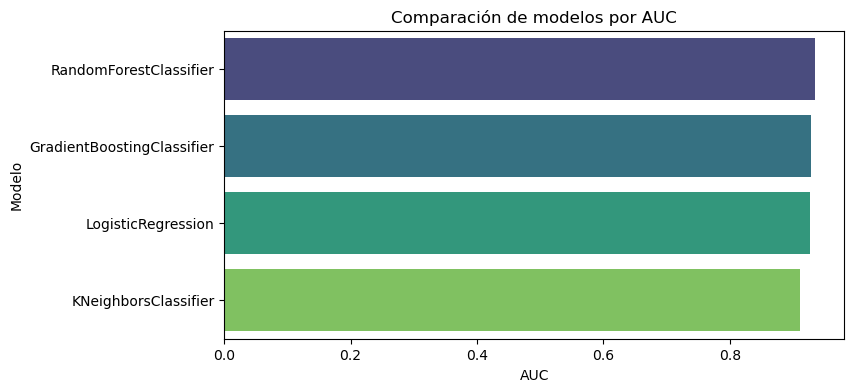

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.barplot(data=df_resultados, x="mejor_auc", y="modelo", palette="viridis")
plt.title("Comparación de modelos por AUC")
plt.xlabel("AUC")
plt.ylabel("Modelo")
plt.show()


### Conclusiones – Etapa 2: Modelado con validación segura

- Se entrenaron cuatro clasificadores utilizando `Pipeline` y `GridSearchCV` con validación cruzada (cv=5).
- El modelo **RandomForestClassifier** obtuvo el mejor desempeño con un **AUC = 0.934** y **Accuracy = 0.875**.
- Los modelos **GradientBoosting** y **LogisticRegression** también mostraron resultados competitivos.
- Se exportó el modelo óptimo (`model.joblib`) para ser desplegado mediante FastAPI en la siguiente etapa.
